In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import zipfile
import requests
from io import BytesIO

url = 'download_url'
response = requests.get(url, stream=True)

if response.status_code == 200:
    zip_file = zipfile.ZipFile(BytesIO(response.content))
    zip_file.extractall('/content/architect')
    print("Датасет завантажено.")
else:
    print("Не вдалось завантажити датасет.")


Files extracted successfully.
Extracted files:


['.config', 'drive', 'architect', 'sample_data']

In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
import seaborn as sns
import shutil

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.models import load_model

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
sns.set_style('whitegrid')

In [ ]:

arch_zero_folder = 'Architecture ZERO'
arch_zero_validation_folder = 'Architecture Validation ZERO'

def gdrive_dataset_path(folder):
    return f'/content/drive/MyDrive/{folder}'

def local_dataset_path(folder):
    return f'/content/dataset/{folder}'

In [ ]:
for folder in [arch_zero_folder, arch_zero_validation_folder]:
    if not os.path.exists(local_dataset_path(folder)):
        shutil.copytree(gdrive_dataset_path(folder), local_dataset_path(folder))

In [ ]:
shutil.copytree(gdrive_dataset_path(arch_zero_validation_folder), local_dataset_path(arch_zero_validation_folder))

'/content/dataset/Architecture Validation ZERO'

In [ ]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [ ]:
dataset = local_dataset_path(arch_zero_folder)
test_dataset = local_dataset_path(arch_zero_validation_folder)

In [ ]:
images = Path(dataset)

files = list(images.glob(r'**/*.JPG')) + list(images.glob(r'**/*.jpg')) + list(images.glob(r'**/*.png')) + list(images.glob(r'**/*.PNG'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], files))

filesPD = pd.Series(files, name='Filepath').astype(str)
labelsPD = pd.Series(labels, name='Label')

image_df = pd.concat([filesPD, labelsPD], axis=1)

In [ ]:
test_images = Path(test_dataset)

test_files = list(test_images.glob(r'**/*.JPG')) + list(test_images.glob(r'**/*.jpg')) + list(test_images.glob(r'**/*.png')) + list(test_images.glob(r'**/*.PNG'))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_files))

test_filesPD = pd.Series(test_files, name='Filepath').astype(str)
test_labelsPD = pd.Series(test_labels, name='Label')

test_image_df = pd.concat([test_filesPD, test_labelsPD], axis=1)

In [ ]:
image_df

,Filepath,Label
0,/content/dataset/Architecture ZERO/Neoclassica...,Neoclassical
1,/content/dataset/Architecture ZERO/Neoclassica...,Neoclassical
2,/content/dataset/Architecture ZERO/Neoclassica...,Neoclassical
3,/content/dataset/Architecture ZERO/Neoclassica...,Neoclassical
4,/content/dataset/Architecture ZERO/Neoclassica...,Neoclassical
...,...,...
3152,/content/dataset/Architecture ZERO/Reneissance...,Reneissance
3153,/content/dataset/Architecture ZERO/Reneissance...,Reneissance
3154,/content/dataset/Architecture ZERO/Reneissance...,Reneissance
3155,/content/dataset/Architecture ZERO/Reneissance...,Reneissance


In [ ]:
import PIL
from pathlib import Path
from PIL import UnidentifiedImageError

path = Path(dataset).rglob("*.jpg")
for img_p in path:
    try:
        img = PIL.Image.open(img_p)
    except PIL.UnidentifiedImageError:
            print(img_p)

<ipython-input-17-26749cfebfeb>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')


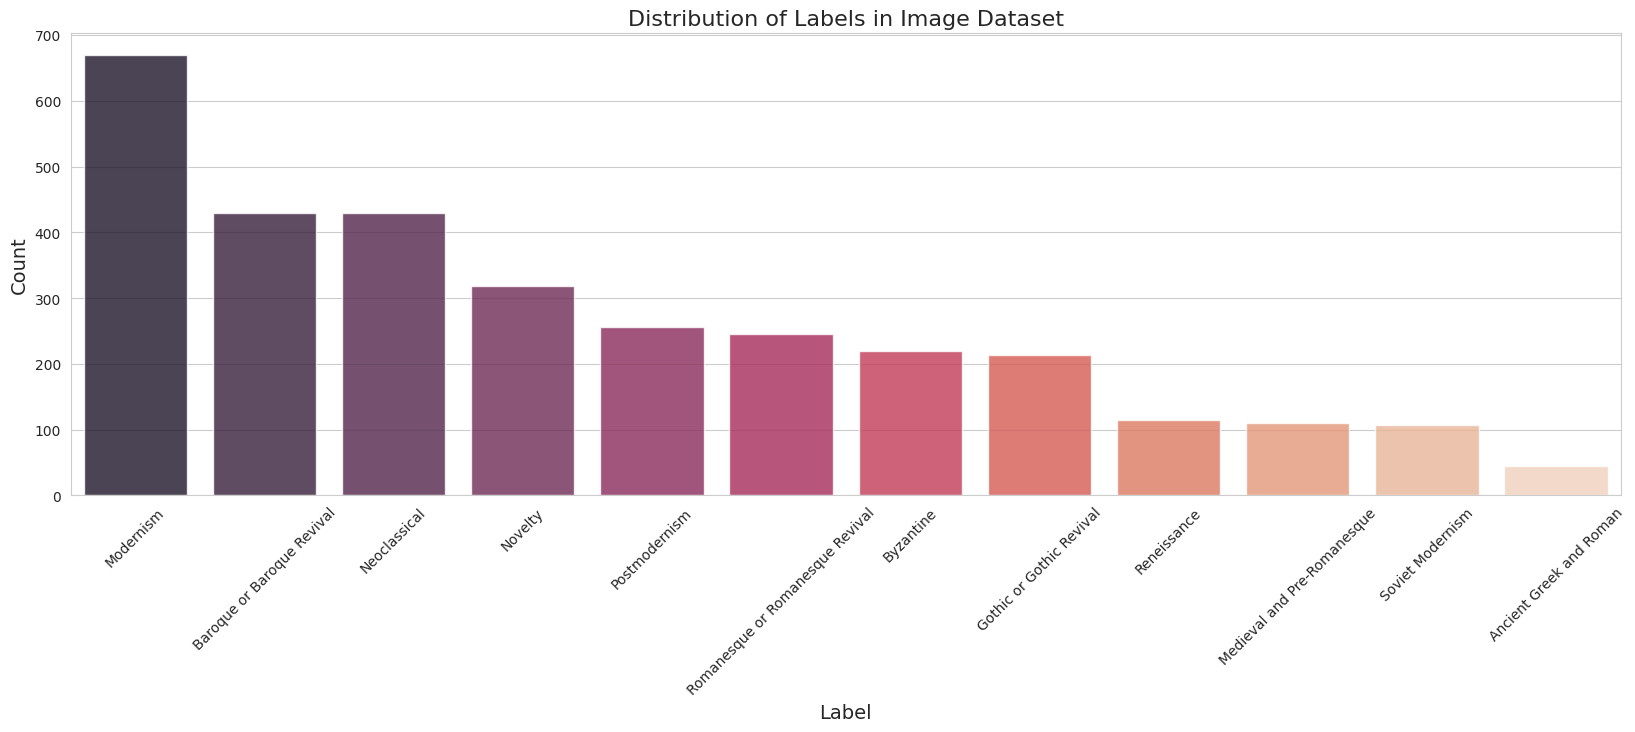

In [ ]:
label_counts = image_df['Label'].value_counts()

plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='rocket')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

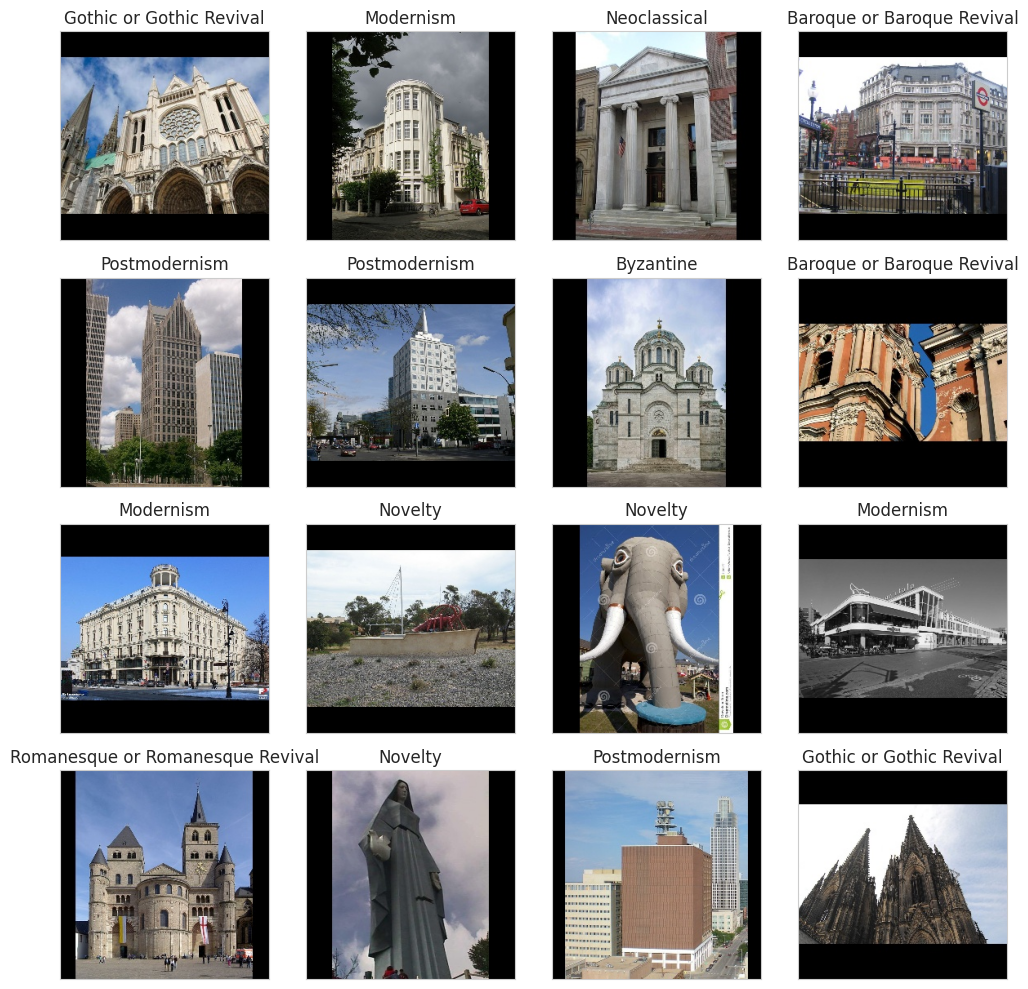

In [ ]:
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

In [ ]:
train_df, val_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)


Found 2525 validated image filenames belonging to 12 classes.
Found 632 validated image filenames belonging to 12 classes.


In [ ]:

test_images = val_generator.flow_from_dataframe(
    dataframe=test_image_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 695 validated image filenames belonging to 12 classes.


In [ ]:
class_labels = list(test_images.class_indices.keys())
print(class_labels)

['Ancient Greek and Roman', 'Baroque or Baroque Revival', 'Byzantine', 'Gothic or Gothic Revival', 'Medieval and Pre-Romanesque', 'Modernism', 'Neoclassical', 'Novelty', 'Postmodernism', 'Reneissance', 'Romanesque or Romanesque Revival', 'Soviet Modernism']


In [ ]:
augment = tf.keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [ ]:
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB7(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
# pretrained_model = tf.keras.applications.VGG16(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )
# pretrained_model = tf.keras.applications.InceptionV3(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )
# pretrained_model = tf.keras.applications.InceptionV3(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )


pretrained_model.trainable = False

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [ ]:

checkpoint_path = "model-efficientnet.weights.h5"
# checkpoint_path = "model-vgg"

checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 10,
                               restore_best_weights = True) # if val loss decreases for 3 epochs in a row, stop training

In [ ]:
inputs = pretrained_model.input
x = augment(inputs)

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)


outputs = Dense(len(class_labels), activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)


In [ ]:
model.summary()
len(model.layers)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling_1[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_2[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 64,461,603 (245.90 MB)

 Trainable params: 363,916 (1.39 MB)

 Non-trainable params: 64,097,687 (244.51 MB)

820

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history_dict):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['loss'], label='Train Loss', marker='o')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    if 'accuracy' in history_dict:
        plt.plot(history_dict['accuracy'], label='Train Accuracy', marker='o')
    if 'val_accuracy' in history_dict:
        plt.plot(history_dict['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


79/79 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.1144 - loss: 4.5637 - val_accuracy: 0.1788 - val_loss: 2.3970
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 298ms/step - accuracy: 0.1168 - loss: 3.2107 - val_accuracy: 0.2247 - val_loss: 2.2576
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 301ms/step - accuracy: 0.1400 - loss: 2.6330 - val_accuracy: 0.2627 - val_loss: 2.2181
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 309ms/step - accuracy: 0.1678 - loss: 2.4801 - val_accuracy: 0.2706 - val_loss: 2.2012
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 306ms/step - accuracy: 0.1765 - loss: 2.4476 - val_accuracy: 0.2991 - val_loss: 2.1832
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 304ms/step - accuracy: 0.1916 - loss: 2.3157 - val_accuracy: 0.3418 - val_loss: 2.1427
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 309ms/step - accuracy: 0.2118 - loss: 2.3177 - val_accuracy: 0.3623 - val_loss: 2.1098
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 39s 281ms/step - accuracy: 0.2261 - loss: 2.2698 - val_accuracy: 0.3623 

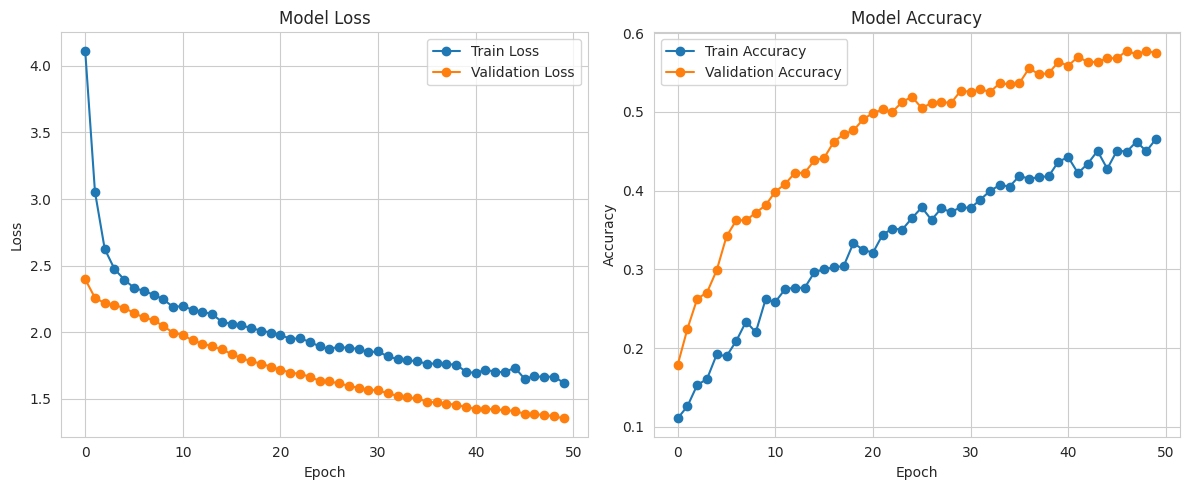

In [ ]:
plot_training_history(history.history)

In [ ]:
history1 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 370ms/step - accuracy: 0.4814 - loss: 1.6307 - val_accuracy: 0.5807 - val_loss: 1.3487
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 21s 268ms/step - accuracy: 0.4750 - loss: 1.6184 - val_accuracy: 0.5807 - val_loss: 1.3510
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 43s 297ms/step - accuracy: 0.4648 - loss: 1.6213 - val_accuracy: 0.5839 - val_loss: 1.3449
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 281ms/step - accuracy: 0.4573 - loss: 1.6316 - val_accuracy: 0.5775 - val_loss: 1.3265
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - accuracy: 0.4791 - loss: 1.5710 - val_accuracy: 0.5791 - val_loss: 1.3141
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 297ms/step - accuracy: 0.4659 - loss: 1.5862 - val_accuracy: 0.5886 - val_loss: 1.3183
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 279ms/step - accuracy: 0.4744 - loss: 1.5479 - val_accuracy: 0.5886 - val_loss: 1.2982
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 275ms/step - accuracy: 0.4918 - loss: 1.5561 - val_accu

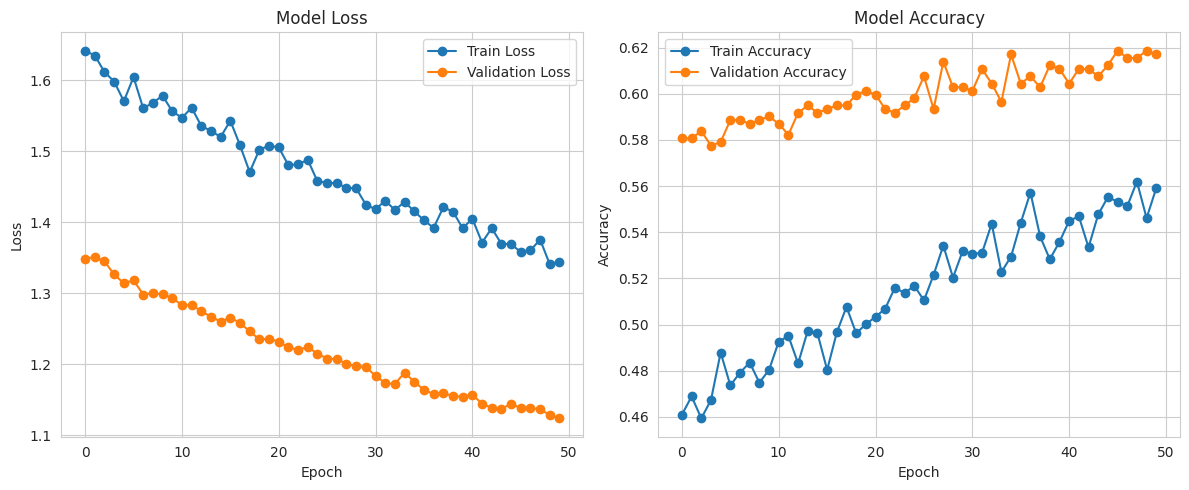

In [ ]:
plot_training_history(history1.history)

In [ ]:

model.compile(
    optimizer=Adam(learning_rate=0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history2 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 152s 997ms/step - accuracy: 0.5458 - loss: 1.3499 - val_accuracy: 0.6155 - val_loss: 1.1489
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 357ms/step - accuracy: 0.5453 - loss: 1.3419 - val_accuracy: 0.6250 - val_loss: 1.1129
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 34s 274ms/step - accuracy: 0.5435 - loss: 1.3647 - val_accuracy: 0.6250 - val_loss: 1.1049
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 47s 351ms/step - accuracy: 0.5621 - loss: 1.2942 - val_accuracy: 0.6297 - val_loss: 1.1132
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 35s 268ms/step - accuracy: 0.5632 - loss: 1.2990 - val_accuracy: 0.6139 - val_loss: 1.1097
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - accuracy: 0.5599 - loss: 1.3190 - val_accuracy: 0.6250 - val_loss: 1.0732
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.5545 - loss: 1.2652 - val_accuracy: 0.6282 - val_loss: 1.0862
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 40s 274ms/step - accuracy: 0.5666 - loss: 1.3158 - val_acc

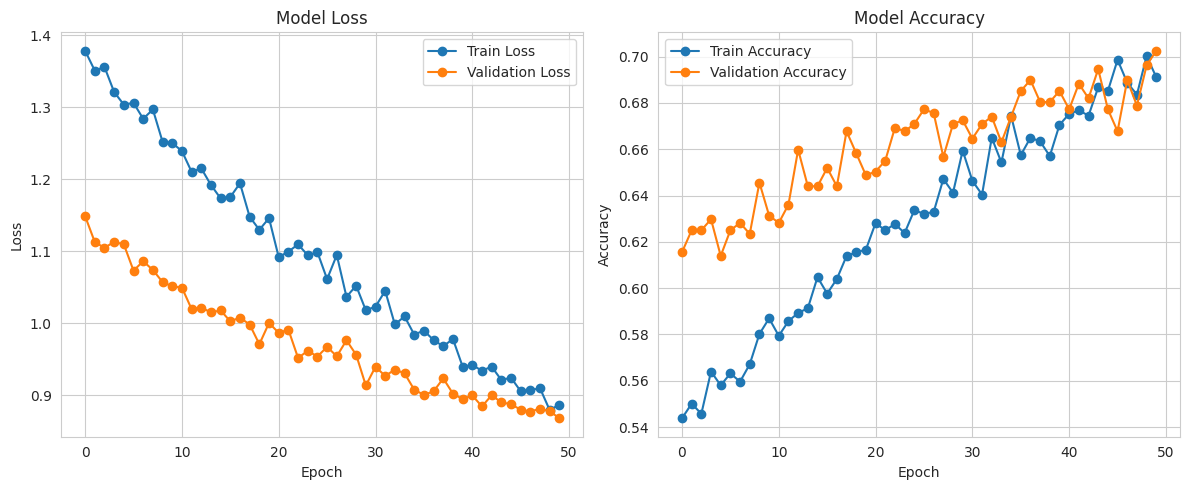

In [ ]:
plot_training_history(history2.history)

In [ ]:
trainable_layers_num = len(pretrained_model.layers)
print(trainable_layers_num)

815


In [ ]:
unfreeze_num_layers = int(trainable_layers_num*0.2)

In [ ]:
pretrained_model.trainable = True
for layer in pretrained_model.layers[:-unfreeze_num_layers]:
  layer.trainable = False
for layer in pretrained_model.layers[-unfreeze_num_layers:]:
  layer.trainable = True

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history3 = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        early_stopping,
        checkpoint_callback,
    ]
)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.5045 - loss: 1.5802 - val_accuracy: 0.7294 - val_loss: 0.8098
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 31s 396ms/step - accuracy: 0.7132 - loss: 0.8637 - val_accuracy: 0.7468 - val_loss: 0.7571
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 410ms/step - accuracy: 0.7730 - loss: 0.6569 - val_accuracy: 0.7152 - val_loss: 0.9500
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 67s 750ms/step - accuracy: 0.8515 - loss: 0.4604 - val_accuracy: 0.7563 - val_loss: 0.8620
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 91s 860ms/step - accuracy: 0.8805 - loss: 0.3417 - val_accuracy: 0.7991 - val_loss: 0.7352
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 33s 413ms/step - accuracy: 0.9066 - loss: 0.2827 - val_accuracy: 0.7864 - val_loss: 0.9629
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 32s 406ms/step - accuracy: 0.9201 - loss: 0.2618 - val_accuracy: 0.7642 - val_loss: 0.9356
Epoch 8/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 41s 413ms/step - accuracy: 0.9365 - loss: 0.2039 - val_accura

KeyboardInterrupt: 

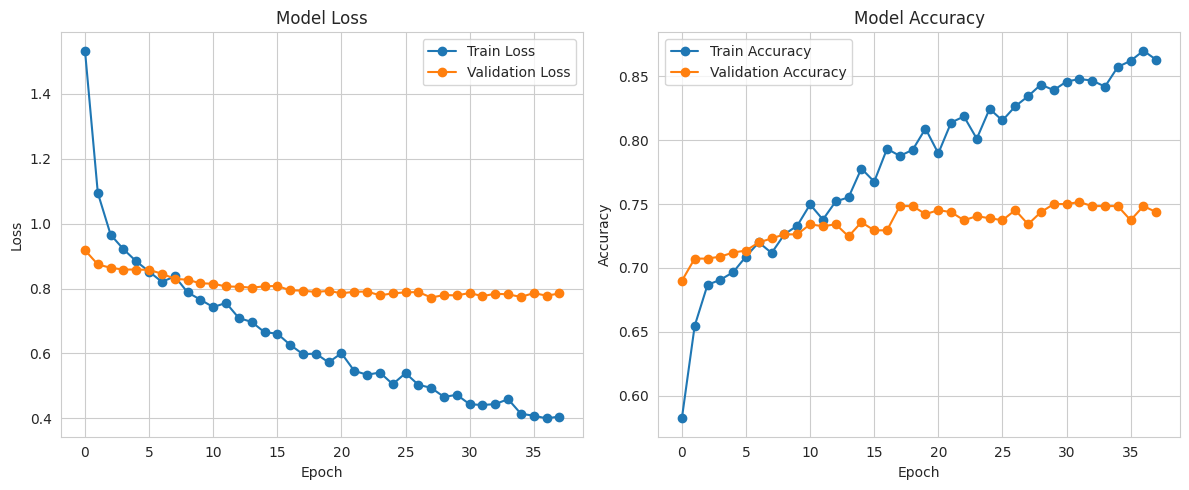

In [ ]:
plot_training_history(history3.history)

In [ ]:
model.save('/content/drive/MyDrive/models/[new]efficient_net_epochs_100(maybe_less).h5')

In [ ]:
model = load_model('/content/drive/MyDrive/models/[new]efficient_net_epochs_100(maybe_less).h5')

In [ ]:
for i in range(80):
  model.layers[len(model.layers)-1-i].trainable = True

In [ ]:
print(len(model.layers))

25


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report
def print_report(predictions):
  predicted_classes = np.argmax(predictions, axis=1)

  true_classes = test_images.classes
  class_labels = list(test_images.class_indices.keys())

  accuracy = accuracy_score(true_classes, predicted_classes)
  print(f"Manual Test Accuracy: {accuracy:.4f}")
  print(classification_report(true_classes, predicted_classes, target_names=class_labels))

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
def draw_confusion_matrix(predictions):
  true_classes = test_images.classes
  class_labels = list(test_images.class_indices.keys())

  predicted_classes = np.argmax(predictions, axis=1)

  conf_matrix = confusion_matrix(true_classes, predicted_classes)

  plt.figure(figsize=(10, 8))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

  plt.xlabel("Predicted Class")
  plt.ylabel("True Class")
  plt.title("Confusion Matrix")
  plt.show()


In [ ]:
import pickle

with open('/content/drive/MyDrive/models/vgg_finetune2.4_10stop_1e-5_history.pkl', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
import pickle

with open('/content/drive/MyDrive/models/model01_history.pkl', 'rb') as file_pi:
    history1 = pickle.load(file_pi)

with open('/content/drive/MyDrive/models/model_150_history.pkl', 'rb') as file_pi:
    history2 = pickle.load(file_pi)

with open('/content/drive/MyDrive/models/model_150_plus_finetune_history.pkl', 'rb') as file_pi:
    history3 = pickle.load(file_pi)

In [ ]:
print(history1)

{'loss': [4.076266765594482, 3.254427433013916, 3.18422794342041, 3.1406683921813965, 3.1063947677612305, 3.075914144515991, 3.013213872909546, 2.9720258712768555, 2.917956590652466, 2.8698623180389404, 2.8348581790924072, 2.7842681407928467, 2.7613656520843506, 2.705493927001953, 2.675945281982422, 2.642721176147461, 2.616537094116211, 2.5979177951812744, 2.5552239418029785, 2.52898907661438, 2.50856351852417, 2.4753828048706055, 2.4675514698028564, 2.454680919647217, 2.4292654991149902, 2.3923890590667725, 2.3866164684295654, 2.3757967948913574, 2.3350484371185303, 2.3366124629974365, 2.313325881958008, 2.2942357063293457, 2.2758617401123047, 2.254260301589966, 2.2605388164520264, 2.2299532890319824, 2.2298262119293213, 2.2031121253967285, 2.201134204864502, 2.194559097290039, 2.1924068927764893, 2.1567797660827637, 2.157428503036499, 2.1408743858337402, 2.120814323425293, 2.120326519012451, 2.1158056259155273, 2.0761587619781494, 2.0888171195983887, 2.0883126258850098, 2.06546211242

In [ ]:
print(history2)

{'loss': [1.7019729614257812, 1.7098510265350342, 1.6908133029937744, 1.6959445476531982, 1.6807055473327637, 1.6818209886550903, 1.6804332733154297, 1.6760672330856323, 1.6620814800262451, 1.6504836082458496, 1.6513561010360718, 1.658758521080017, 1.6469686031341553, 1.6474418640136719, 1.633753776550293, 1.6350462436676025, 1.6263219118118286, 1.6300654411315918, 1.6212502717971802, 1.6042407751083374, 1.608892798423767, 1.6020184755325317, 1.6041134595870972, 1.6030868291854858, 1.604129433631897, 1.6065621376037598, 1.5706297159194946, 1.5773637294769287, 1.5811128616333008, 1.5716670751571655, 1.5763466358184814, 1.5667095184326172, 1.5688997507095337, 1.5647674798965454, 1.5433220863342285, 1.5337761640548706, 1.5487000942230225, 1.5524909496307373, 1.5324313640594482, 1.5388803482055664, 1.5395455360412598, 1.5341659784317017, 1.5137648582458496, 1.522676944732666, 1.5274646282196045, 1.5198928117752075, 1.5062302350997925, 1.5085760354995728, 1.5004945993423462, 1.4924144744873

In [ ]:
print(history3)

{'loss': [2.4194464683532715, 2.0027456283569336, 1.764999270439148, 1.602752923965454, 1.4605562686920166, 1.3411898612976074, 1.2357672452926636, 1.1520084142684937, 1.0642846822738647, 0.9847112894058228, 0.9269518256187439, 0.8576194643974304, 0.779322624206543, 0.7176640033721924, 0.6806983947753906, 0.6316145658493042, 0.5984788537025452, 0.5524007678031921, 0.5069357752799988, 0.4624394178390503, 0.4299580454826355, 0.4417218863964081, 0.3728635311126709, 0.36706942319869995, 0.34452953934669495, 0.3569091260433197, 0.32918781042099], 'accuracy': [0.2817942500114441, 0.36452004313468933, 0.4288173317909241, 0.4765087068080902, 0.523896336555481, 0.5562980771064758, 0.5930538773536682, 0.6220129728317261, 0.6473268270492554, 0.6750708818435669, 0.6962332725524902, 0.720332145690918, 0.7465572953224182, 0.7656946182250977, 0.780376672744751, 0.7981976270675659, 0.8109558820724487, 0.8261441588401794, 0.8412312865257263, 0.8542932271957397, 0.8631024956703186, 0.8644188046455383, 0

22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 879ms/step
Manual Test Accuracy: 0.7266
                                  precision    recall  f1-score   support

         Ancient Greek and Roman       0.67      0.31      0.42        13
      Baroque or Baroque Revival       0.65      0.80      0.71       108
                       Byzantine       0.87      0.83      0.85        58
        Gothic or Gothic Revival       0.76      0.76      0.76        50
     Medieval and Pre-Romanesque       0.60      0.21      0.32        14
                       Modernism       0.68      0.82      0.74       124
                    Neoclassical       0.82      0.80      0.81       100
                         Novelty       0.88      0.95      0.92        64
                   Postmodernism       0.78      0.59      0.67        66
                     Reneissance       1.00      0.03      0.06        33
Romanesque or Romanesque Revival       0.52      0.78      0.62        41
                Soviet Modernism       0

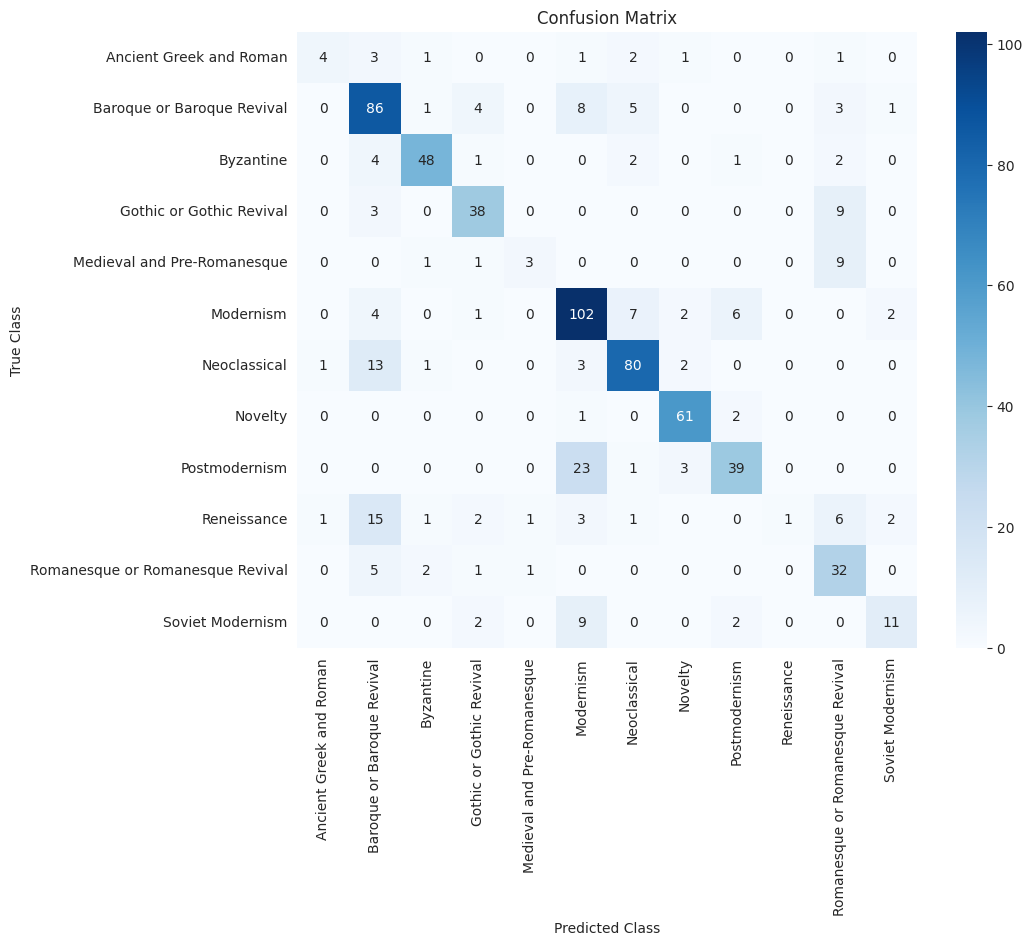

In [ ]:
predictions = model.predict(test_images)
print_report(predictions)
draw_confusion_matrix(predictions)